In [562]:
import random
from typing import Any, Dict
import datasets
import torch
import torchvision
from torchvision.transforms import v2 as transforms
import torchvision.transforms.functional as vF
import matplotlib.pyplot as plt
%matplotlib inline

In [557]:
ok_vqa_builder = datasets.load_dataset_builder('HuggingFaceM4/OK-VQA', trust_remote_code=False)
ok_vqa_builder.download_and_prepare(file_format='arrow')
ds = ok_vqa_builder.as_dataset()
train = ds['train'].to_iterable_dataset(num_shards=8)
valid = ds['validation'].to_iterable_dataset(num_shards=8)
train = train.shuffle(seed=42)
train = valid.shuffle(seed=42)

Using the latest cached version of the module from /home/eihli/.cache/huggingface/modules/datasets_modules/datasets/HuggingFaceM4--OK-VQA/33fb0e5856ea617c9d69b3feb4c67fba7ff98fd7b38e19bebc285b87e68326fb (last modified on Thu Mar 28 15:57:27 2024) since it couldn't be found locally at HuggingFaceM4/OK-VQA, or remotely on the Hugging Face Hub.


In [544]:
it = iter(train)
example = next(it)

In [545]:
image = example['image']

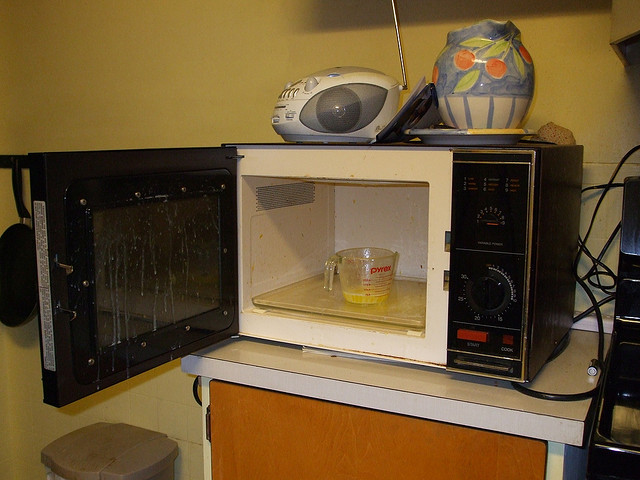

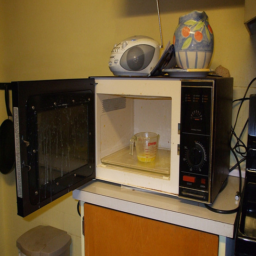

(None, None)

In [546]:
display(image), display(transforms.Resize(size=(256, 256))(image))

In [547]:
class IdentityTransform():
    def __call__(self, sample: Any):
        return sample
        
class VqaDataset(datasets.IterableDataset):
    def __init__(self, dataset: datasets.Dataset, transform=IdentityTransform()):
        self.transform = transform
        self.dataset = dataset.to_iterable_dataset(num_shards=8).shuffle(seed=42)

    def __iter__(self):
        for sample in iter(self.dataset):
            answers = sample['answers']
            del sample['answers']
            sample.update(random.choice(answers))
            yield self.transform(sample)

In [548]:
vqa_transforms = transforms.Compose([
    transforms.PILToTensor(),
    transforms.CenterCrop(size=min(*image.size)),
    transforms.Resize(size=(256, 256))
])

In [549]:
xfids = VqaDataset(ds['train'], vqa_transforms)
xfidsit = iter(xfids)

In [550]:
example = next(xfidsit)
img = example['image']
example

{'image': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'question_type': 'two',
 'confidence': 2,
 'image_id': 190839,
 'answer_type': 'other',
 'question_id': 1908395,
 'question': 'What year was the first one of these available to the general public?',
 'answer': '1990',
 'raw_answer': '1990',
 'answer_confidence': 'yes',

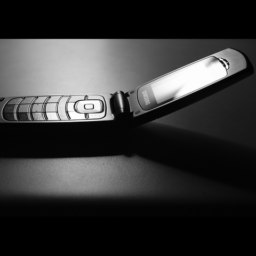

In [551]:
display(vF.to_pil_image(img))

In [552]:
from torch.utils.data import DataLoader

In [553]:
dl = DataLoader(xfids, batch_size=4)

In [554]:
dlit = iter(dl)

In [570]:
batch = next(dlit)
batch['image'].shape

torch.Size([4, 3, 256, 256])

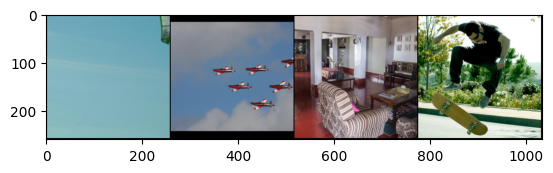

In [571]:
grid = torchvision.utils.make_grid(batch['image'], nrow=4)
plt.imshow(torch.permute(grid, (1, 2, 0)))